It is a pain to have to keep dumping compute and garbage text files just to regenerate J each time.
The point of this notebook is to carefully review the process of J calculation,
so that we can perform it just once and save to the result to a shared numpy zip file.

In [1]:
%matplotlib inline
import skyflux as sf

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [3]:
def stokes_plotter(dv_dict, dv_label):
    plt.clf()
    
    x = dv_dict[dv_dict['label']]
    dv_list = dv_dict[dv_label]

    im = np.imag(dv_list)
    re = np.real(dv_list)
    ab = np.abs(dv_list)
    plt.plot(x, im, label="imaginary")
    plt.plot(x, re, label="real")
    plt.plot(x, ab, label="abs")

    plt.title(dv_label + " over " + dv_dict['label'])
    plt.legend()
    plt.xlabel(dv_dict['label'] + " [rad]")
    plt.ylabel(dv_label + " [Jy]")

    plt.show()

In [4]:
dec_decf = np.radians(-30.72)
ra_decf = 0
list_xx_over_ra = []
list_yy_over_ra = []
list_ra = []

while ra_decf <= 120:
    ra = np.radians(ra_decf)
    J_decf = sf.stokes.create_J(ra=ra, dec=dec_decf, lst=np.pi/3, radians=True)
    list_ra.append(ra)
    list_xx_over_ra.append(J_decf[0][0][0])
    list_yy_over_ra.append(J_decf[0][1][1])
    ra_decf += 10

dict_ra = {
    'label': 'RA',
    'RA': list_ra,
    'xx': np.array(list_xx_over_ra),
    'yy': np.array(list_yy_over_ra)
}

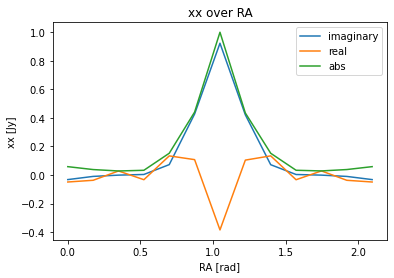

In [5]:
stokes_plotter(dict_ra, 'xx')

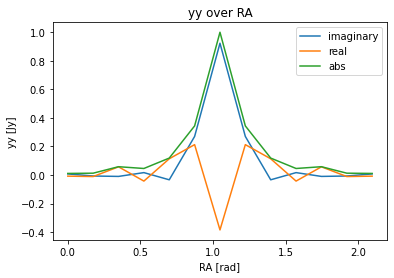

In [6]:
stokes_plotter(dict_ra, 'yy')

In [7]:
ra_raf = np.radians(59.98479)
dec_raf = -40.72
list_xx_over_dec = []
list_yy_over_dec = []
list_dec = []

while dec_raf <= -20.72:
    dec = np.radians(dec_raf)
    J_raf = sf.stokes.create_J(
        ra=ra_raf, dec=dec, lst=np.pi/3, radians=True
    )
    list_dec.append(dec)
    list_xx_over_dec.append(J_raf[0][0][0])
    list_yy_over_dec.append(J_raf[0][1][1])
    dec_raf += 5

dict_dec = {
    'label': 'dec',
    'dec': list_dec,
    'xx': np.array(list_xx_over_dec),
    'yy': np.array(list_yy_over_dec)
}

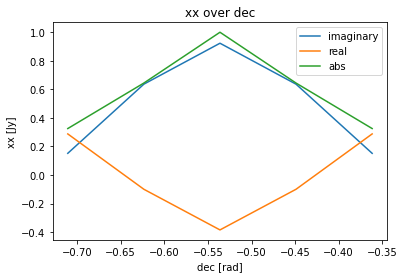

In [8]:
stokes_plotter(dict_dec, 'xx')

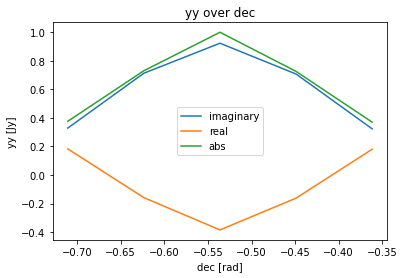

In [9]:
stokes_plotter(dict_dec, 'yy')

In [10]:
# Fixed equatorial coordinates, to examine time dependence of topocentric coordinates
fra = np.pi / 2 # arbitrary choice that I am hoping is close to one of the actual sources
fdec = np.radians(sf.rot.hera_lat)
list_lst = np.linspace(0, 2 * np.pi, 100)

list_xx_over_lst = []
list_yy_over_lst = []

for lst in list_lst:
    az, alt = sf.rot.eq_to_topo(fra, fdec, lst=lst, radians=True)
    J_ff = sf.stokes.create_J(az=az, alt=alt, lst=lst, radians=True)
    
    list_xx_over_lst.append(J_ff[0][0][0])
    list_yy_over_lst.append(J_ff[0][1][1])
    dec_raf += 5

dict_lst = {
    'label': 'lst',
    'lst': list_lst,
    'xx': np.array(list_xx_over_lst),
    'yy': np.array(list_yy_over_lst)
}

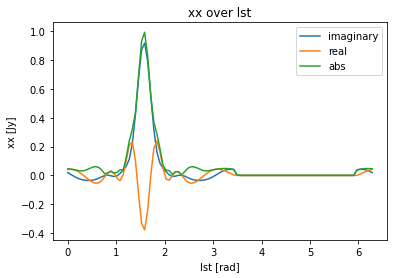

In [11]:
stokes_plotter(dict_lst, 'xx')

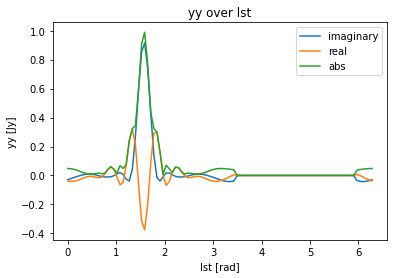

In [12]:
# Idea 1: approximate all space as zero except for the spike, should dramatically cut down on number of resolved pixels
# Idea 1A: approximate the spike as symmetric, which should cut in half the remaining entries to be stored
# Idea 2: speed up CPU at the cost of RAM by precalculating all source-paths in bulk
stokes_plotter(dict_lst, 'yy')